Smart Traffic Signal System - ML Project
----------------------------------------
This project implements a comprehensive traffic management system using multiple
machine learning algorithms to optimize traffic flow, detect traffic patterns,
classify vehicles, and adjust signal timings.

Key Functionalities:
1. Traffic Flow Prediction using Linear Regression
2. Vehicle Type Classification using Decision Trees
3. Traffic Pattern Clustering using K-Means
4. Signal Timing Optimization using Reinforcement Learning
5. Emergency Vehicle Detection using basic computer vision

Imports:

In [7]:
import os
os.environ['PYTHONIOENCODING'] = 'UTF-8'  # Before any other imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import os
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, silhouette_score
from datetime import datetime, timedelta

Set seed for reproducibility

In [8]:
np.random.seed(42)

Define Classes

In [9]:
class TrafficFlowPredictor:
    """
    Predicts traffic flow based on historical data using Linear Regression.
    Features: Time of day, Day of week, Weather conditions
    Target: Number of vehicles
    """

    def __init__(self, data_file="traffic_data.csv"):
        self.model = LinearRegression()
        self.scaler = StandardScaler()
        self.is_trained = False
        self.data_file = data_file

    def load_data(self):
        """Load data from an existing CSV file"""
        if not os.path.exists(self.data_file):
            raise FileNotFoundError(f"Data file '{self.data_file}' not found. Please generate or provide the dataset.")

        df = pd.read_csv(self.data_file)
        X = df[['hour', 'day', 'weather']].values
        y = df['vehicle_count'].values
        return X, y

    
    def train(self, X=None, y=None):
        """Train the traffic flow prediction model"""
        if X is None or y is None:
            X, y = self.generate_sample_data()
        
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Train model
        self.model.fit(X_train_scaled, y_train)
        
        # Evaluate model
        y_pred = self.model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        self.is_trained = True
        
        return {
            'rmse': rmse,
            'coefficients': self.model.coef_,
            'intercept': self.model.intercept_
        }
    '''The train function is responsible for training a traffic flow prediction model. 
It first checks if input features (X) and labels (y) are provided; if not, it generates sample data. 
The data is then split into training and testing sets using an 80-20 split. Feature scaling is applied to standardize the input data using a pre-defined scaler. 
The model is trained on the scaled training data, and then evaluated by predicting values on the test set. 
The evaluation metrics calculated include the Root Mean Squared Error (RMSE), which quantifies prediction accuracy. 
Finally, the function sets a flag indicating the model is trained and returns the RMSE, model coefficients, and intercept.
'''    

    def predict(self, hour, day, weather):
        """Predict traffic flow for given conditions"""
        if not self.is_trained:
            self.train()
        
        features = np.array([[hour, day, weather]])
        scaled_features = self.scaler.transform(features)
        prediction = self.model.predict(scaled_features)[0]
        
        return max(5, int(prediction))
    
    def save_model(self, filepath='models/traffic_flow_predictor.pkl'):
        """Save trained model to disk"""
        if not self.is_trained:
            raise ValueError("Model not trained yet")
        
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        
        with open(filepath, 'wb') as f:
            pickle.dump({
                'model': self.model,
                'scaler': self.scaler,
                'is_trained': self.is_trained
            }, f)
    
    def load_model(self, filepath='models/traffic_flow_predictor.pkl'):
        """Load trained model from disk"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.model = data['model']
            self.scaler = data['scaler']
            self.is_trained = data['is_trained']


class VehicleClassifier:
    """
    Classifies vehicles into categories based on features using Decision Trees.
    Vehicle categories: Car, Truck, Motorcycle, Bus
    """
    
    def __init__(self):
        self.model = DecisionTreeClassifier(random_state=42)
        self.is_trained = False
        self.classes = ['Car', 'Truck', 'Motorcycle', 'Bus']
    
    def generate_sample_data(self, n_samples=500):
        """Generate synthetic vehicle data for demonstration"""
        # Features: length, width, speed, shape_factor
        
        # Generate random vehicle types
        vehicle_types = np.random.randint(0, 4, n_samples)
        
        # Initialize feature arrays
        length = np.random.normal(0, 0.8, n_samples)
        width = np.zeros(n_samples)
        speed = np.zeros(n_samples)
        shape_factor = np.zeros(n_samples)
        
        # Generate features based on vehicle type with some random variation
        for i in range(n_samples):
            if vehicle_types[i] == 0:  # Car
                length[i] = np.random.normal(4.5, 0.5)
                width[i] = np.random.normal(1.8, 0.2)
                speed[i] = np.random.normal(60, 15)
                shape_factor[i] = np.random.normal(0.75, 0.05)
            elif vehicle_types[i] == 1:  # Truck
                length[i] = np.random.normal(8.0, 1.0)
                width[i] = np.random.normal(2.5, 0.3)
                speed[i] = np.random.normal(50, 10)
                shape_factor[i] = np.random.normal(0.9, 0.05)
            elif vehicle_types[i] == 2:  # Motorcycle
                length[i] = np.random.normal(2.0, 0.3)
                width[i] = np.random.normal(0.8, 0.1)
                speed[i] = np.random.normal(70, 20)
                shape_factor[i] = np.random.normal(0.4, 0.05)
            else:  # Bus
                length[i] = np.random.normal(12.0, 1.5)
                width[i] = np.random.normal(2.6, 0.2)
                speed[i] = np.random.normal(45, 8)
                shape_factor[i] = np.random.normal(0.85, 0.05)
        
        # Create features matrix
        X = np.column_stack([length, width, speed, shape_factor])
        y = vehicle_types
        
        return X, y
    
    def train(self, X=None, y=None):
        """Train the vehicle classification model"""
        if X is None or y is None:
            X, y = self.generate_sample_data()
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train model
        self.model.fit(X_train, y_train)
        
        # Evaluate
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        self.is_trained = True
        
        return {
            'accuracy': accuracy,
            'importance': self.model.feature_importances_
        }
    
    def predict(self, length, width, speed, shape_factor):
        """Predict vehicle type based on features"""
        if not self.is_trained:
            self.train()
        
        features = np.array([[length, width, speed, shape_factor]])
        prediction = self.model.predict(features)[0]
        
        return self.classes[prediction]
    
    def save_model(self, filepath='models/vehicle_classifier.pkl'):
        """Save trained model to disk"""
        if not self.is_trained:
            raise ValueError("Model not trained yet")
        
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        
        with open(filepath, 'wb') as f:
            pickle.dump({
                'model': self.model,
                'is_trained': self.is_trained,
                'classes': self.classes
            }, f)
    
    def load_model(self, filepath='models/vehicle_classifier.pkl'):
        """Load trained model from disk"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.model = data['model']
            self.is_trained = data['is_trained']
            self.classes = data['classes']


class TrafficPatternAnalyzer:
    """
    Analyzes and clusters traffic patterns using K-Means algorithm
    """

    def __init__(self, n_clusters=4, data_file="traffic_patterns.csv"):
        self.model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.scaler = StandardScaler()
        self.is_trained = False
        self.n_clusters = n_clusters
        self.data_file = data_file

    def load_data(self):
        """Load traffic pattern data from CSV"""
        if not os.path.exists(self.data_file):
            raise FileNotFoundError(f"Data file '{self.data_file}' not found. Please generate or provide the dataset.")

        df = pd.read_csv(self.data_file)
        X = df[['average_speed', 'vehicle_density', 'average_waiting_time', 'flow_direction_ratio']].values
        return X
    
    # def train(self, X=None):
    #     """Train the traffic pattern clustering model"""
    #     if X is None:
    #         X = self.load_data()

    #     # Scale features
    #     X_scaled = self.scaler.fit_transform(X)
        
    #     # Train model
    #     self.model.fit(X_scaled)
        
    #     # Evaluate
    #     labels = self.model.labels_
    #     centers = self.model.cluster_centers_
    #     silhouette = silhouette_score(X_scaled, labels)
        
    #     self.is_trained = True
        
    #     return {
    #         'silhouette_score': silhouette,
    #         'cluster_centers': centers,
    #         'labels': labels
    #     }

    def train(self, X=None, test_size=0.2, random_state=42):
        """Train the traffic pattern clustering model and evaluate using train-test split"""
        if X is None:
            X = self.load_data()

        # Split into train and test sets
        X_train, X_test = train_test_split(X, test_size=test_size, random_state=random_state)

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train model
        self.model.fit(X_train_scaled)

        # Evaluate
        train_labels = self.model.labels_
        train_silhouette = silhouette_score(X_train_scaled, train_labels)

        test_labels = self.model.predict(X_test_scaled)
        test_silhouette = silhouette_score(X_test_scaled, test_labels)

        self.is_trained = True

        return {
            'train_silhouette_score': train_silhouette,
            'test_silhouette_score': test_silhouette,
            'cluster_centers': self.model.cluster_centers_,
            'train_labels': train_labels,
            'test_labels': test_labels
        }


    
    def predict_pattern(self, avg_speed, density, wait_time, flow_ratio):
        """Predict traffic pattern for given conditions"""
        if not self.is_trained:
            self.train()
        
        features = np.array([[avg_speed, density, wait_time, flow_ratio]])
        scaled_features = self.scaler.transform(features)
        cluster = self.model.predict(scaled_features)[0]
        
        pattern_names = ['Rush Hour Congestion', 'Free-flowing Traffic', 
                         'Moderate Congestion', 'Light Traffic']
        
        return {
            'cluster_id': cluster,
            'pattern_name': pattern_names[cluster]
        }
    
    def save_model(self, filepath='models/traffic_pattern_analyzer.pkl'):
        """Save trained model to disk"""
        if not self.is_trained:
            raise ValueError("Model not trained yet")
        
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        
        with open(filepath, 'wb') as f:
            pickle.dump({
                'model': self.model,
                'scaler': self.scaler,
                'is_trained': self.is_trained,
                'n_clusters': self.n_clusters
            }, f)
    
    def load_model(self, filepath='models/traffic_pattern_analyzer.pkl'):
        """Load trained model from disk"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.model = data['model']
            self.scaler = data['scaler']
            self.is_trained = data['is_trained']
            self.n_clusters = data['n_clusters']


class SignalTimingOptimizer:
    """
    Optimizes traffic signal timings using Q-learning (a form of Reinforcement Learning)
    """
    
    def __init__(self, n_states=10, n_actions=5, learning_rate=0.1, discount_factor=0.9):
        self.n_states = n_states  # Number of traffic states
        self.n_actions = n_actions  # Number of possible signal timing settings
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.q_table = np.zeros((n_states, n_actions))
        self.is_trained = False
    
    def encode_state(self, traffic_flow, time_of_day, day_type):
        """
        Encode traffic conditions into a state index
        
        Args:
            traffic_flow: integer representing vehicles per minute (0-50+)
            time_of_day: hour of day (0-23)
            day_type: 0 for weekday, 1 for weekend
        
        Returns:
            state index (0 to n_states-1)
        """
        # Convert traffic flow to a category (0-4)
        if traffic_flow < 10:
            flow_cat = 0  # Very light
        elif traffic_flow < 20:
            flow_cat = 1  # Light
        elif traffic_flow < 30:
            flow_cat = 2  # Moderate
        elif traffic_flow < 40:
            flow_cat = 3  # Heavy
        else:
            flow_cat = 4  # Very heavy
        
        # Convert time to category (0-1)
        if 7 <= time_of_day < 19:
            time_cat = 1  # Daytime
        else:
            time_cat = 0  # Nighttime
        
        # Combine categories to get state index
        state = flow_cat + (5 * time_cat) + (10 * day_type)
        
        # Ensure state is within bounds
        return min(state, self.n_states - 1)
    
    def get_action_timing(self, action):
        """Convert action index to signal timing in seconds"""
        # Action 0: 15s, Action 1: 30s, Action 2: 45s, Action 3: 60s, Action 4: 75s
        return (action + 1) * 15
    
    def calculate_reward(self, state, action, next_state):
        """
        Calculate reward for taking action in state leading to next_state
        This is a simplified reward function based on traffic flow and timing
        """
        # Extract flow category from state
        flow_cat = state % 5
        
        # Get timing for the selected action
        timing = self.get_action_timing(action)
        
        # Base reward - negative value representing waiting time
        base_reward = -timing
        
        # Add bonus for appropriate timing relative to flow
        if flow_cat == 0 and timing <= 30:  # Very light traffic, short timing
            bonus = 10
        elif flow_cat == 1 and 15 <= timing <= 45:  # Light traffic
            bonus = 10
        elif flow_cat == 2 and 30 <= timing <= 60:  # Moderate traffic
            bonus = 10
        elif flow_cat == 3 and 45 <= timing <= 75:  # Heavy traffic
            bonus = 10
        elif flow_cat == 4 and timing >= 60:  # Very heavy traffic, long timing
            bonus = 10
        else:
            bonus = 0
        
        return base_reward + bonus
    
    def train(self, episodes=1000):
        """Train the RL model using Q-learning"""
        for episode in range(episodes):
            # Start in a random state
            state = np.random.randint(0, self.n_states)
            
            # Generate a random number of steps for this episode
            steps = np.random.randint(10, 30)
            
            for step in range(steps):
                # Choose action using epsilon-greedy policy
                epsilon = max(0.1, 1.0 - episode / (episodes * 0.8))  # Decrease exploration over time
                
                if np.random.random() < epsilon:
                    action = np.random.randint(0, self.n_actions)  # Explore
                else:
                    action = np.argmax(self.q_table[state])  # Exploit
                
                # Simulate next state and reward
                next_state = (state + np.random.randint(-1, 2)) % self.n_states
                reward = self.calculate_reward(state, action, next_state)
                
                # Update Q-value
                best_next_action = np.argmax(self.q_table[next_state])
                td_target = reward + self.discount_factor * self.q_table[next_state, best_next_action]
                td_error = td_target - self.q_table[state, action]
                self.q_table[state, action] += self.learning_rate * td_error
                
                # Move to next state
                state = next_state
        
        self.is_trained = True
        
        return {
            'q_table': self.q_table.copy()
        }
    
    def get_optimal_timing(self, traffic_flow, time_of_day, day_type):
        """Get optimal signal timing for given traffic conditions"""
        if not self.is_trained:
            self.train()
        
        state = self.encode_state(traffic_flow, time_of_day, day_type)
        action = np.argmax(self.q_table[state])
        timing = self.get_action_timing(action)
        
        return {
            'state': state,
            'action': action,
            'timing_seconds': timing
        }
    
    def save_model(self, filepath='models/signal_timing_optimizer.pkl'):
        """Save trained model to disk"""
        if not self.is_trained:
            raise ValueError("Model not trained yet")
        
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        
        with open(filepath, 'wb') as f:
            pickle.dump({
                'q_table': self.q_table,
                'n_states': self.n_states,
                'n_actions': self.n_actions,
                'learning_rate': self.learning_rate,
                'discount_factor': self.discount_factor,
                'is_trained': self.is_trained
            }, f)
    
    def load_model(self, filepath='models/signal_timing_optimizer.pkl'):
        """Load trained model from disk"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.q_table = data['q_table']
            self.n_states = data['n_states']
            self.n_actions = data['n_actions']
            self.learning_rate = data['learning_rate']
            self.discount_factor = data['discount_factor']
            self.is_trained = data['is_trained']


class EmergencyVehicleDetector:
    """
    Detects emergency vehicles from images using basic computer vision techniques
    """
    
    def __init__(self):
        self.emergency_color_ranges = {
    'red': {'lower': np.array([0, 120, 100]), 'upper': np.array([10, 255, 255])},
    'blue': {'lower': np.array([100, 150, 50]), 'upper': np.array([140, 255, 200])}
}

    def generate_sample_image(self, has_emergency=False):
        """Generate a sample traffic image with or without emergency vehicles"""
        # Create a blank image (road scene)
        image = np.ones((300, 400, 3), dtype=np.uint8) * 100  # Gray road
        
        # Add lane markings
        cv2.line(image, (200, 0), (200, 300), (255, 255, 255), 2)
        cv2.line(image, (100, 0), (100, 300), (255, 255, 255), 2)
        cv2.line(image, (300, 0), (300, 300), (255, 255, 255), 2)
        
        # Add some regular vehicles (rectangles)
        for _ in range(np.random.randint(3, 8)):
            x = np.random.randint(50, 350)
            y = np.random.randint(30, 270)
            w = np.random.randint(30, 60)
            h = np.random.randint(20, 40)
            color = (np.random.randint(0, 100), np.random.randint(0, 100), np.random.randint(0, 100))
            cv2.rectangle(image, (x, y), (x+w, y+h), color, -1)
        
        # Add emergency vehicle if requested
        if has_emergency:
            # Position for emergency vehicle
            x = np.random.randint(50, 300)
            y = np.random.randint(30, 240)
            w = np.random.randint(40, 70)
            h = np.random.randint(25, 45)
            
            # Draw vehicle body
            cv2.rectangle(image, (x, y), (x+w, y+h), (30, 30, 30), -1)
            
            # Add emergency lights (red and blue)
            light_w = w // 4
            
            # Random choice between red and blue dominant lights
            if np.random.random() > 0.5:
                # Red lights
                cv2.rectangle(image, (x+5, y+5), (x+light_w, y+10), (0, 0, 255), -1)
                cv2.rectangle(image, (x+w-light_w-5, y+5), (x+w-5, y+10), (255, 0, 0), -1)
            else:
                # Blue lights
                cv2.rectangle(image, (x+5, y+5), (x+light_w, y+10), (255, 0, 0), -1)
                cv2.rectangle(image, (x+w-light_w-5, y+5), (x+w-5, y+10), (0, 0, 255), -1)
        
        return image
    
    def detect_emergency_vehicle(self, image):
        """
        Detect emergency vehicles in the image based on color patterns
        
        Args:
            image: BGR image (numpy array)
            
        Returns:
            Dictionary with detection results
        """
        # Convert to HSV color space for better color detection
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Initialize emergency vehicle detection flags
        red_detected = False
        blue_detected = False
        
        # Check for red emergency lights
        red_mask = cv2.inRange(hsv, self.emergency_color_ranges['red']['lower'], 
                              self.emergency_color_ranges['red']['upper'])
        red_pixels = cv2.countNonZero(red_mask)
        
        # Check for blue emergency lights
        blue_mask = cv2.inRange(hsv, self.emergency_color_ranges['blue']['lower'],
                               self.emergency_color_ranges['blue']['upper'])
        blue_pixels = cv2.countNonZero(blue_mask)
        
        # Determine if emergency vehicle is present based on color thresholds
        if red_pixels > 100:
            red_detected = True
        
        if blue_pixels > 100:
            blue_detected = True
        
        # Combined detection result
        emergency_detected = red_detected or blue_detected
        
        return {
            'emergency_detected': emergency_detected,
            'red_lights_detected': red_detected,
            'blue_lights_detected': blue_detected,
            'red_pixel_count': red_pixels,
            'blue_pixel_count': blue_pixels
        }
    
    def process_image(self, image=None, show_results=False):
        """Process an image and detect emergency vehicles"""
        if image is None:
            # Generate a sample image with 30% chance of emergency vehicle
            has_emergency = np.random.random() < 0.3
            image = self.generate_sample_image(has_emergency)
        
        # Detect emergency vehicles
        results = self.detect_emergency_vehicle(image)
        
        if show_results:
            # Create a copy for visualization
            vis_image = image.copy()
            
            # Add text with detection results
            text = "Emergency: {}".format("YES" if results['emergency_detected'] else "NO")
            cv2.putText(vis_image, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                       (0, 0, 255) if results['emergency_detected'] else (0, 255, 0), 2)
            
            # Show the image
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
            plt.title("Emergency Vehicle Detection")
            plt.axis('off')
            plt.show()
        
        return results


class SmartTrafficSystem:
    """
    Main class that integrates all components of the smart traffic signal system
    """
    
    def __init__(self):
        self.flow_predictor = TrafficFlowPredictor()
        self.vehicle_classifier = VehicleClassifier()
        self.pattern_analyzer = TrafficPatternAnalyzer()
        self.signal_optimizer = SignalTimingOptimizer()
        self.emergency_detector = EmergencyVehicleDetector()
        self.vehicle_counts = {'Car': 0, 'Truck': 0, 'Motorcycle': 0, 'Bus': 0}  # Added line

        
        # Intersection state
        self.current_signal_phase = 0  # 0: N-S green, E-W red; 1: N-S red, E-W green
        self.emergency_mode = False
        self.current_timing = 30  # Default timing in seconds
        
        # Initialize models
        self._initialize_models()
    
    def _initialize_models(self):
        """Initialize all ML models"""
        print("\nInitializing traffic flow predictor...")
        try:
            X, y = self.flow_predictor.load_data()
            self.flow_predictor.train(X, y)
            print("Traffic flow predictor trained using CSV data.")
        except FileNotFoundError as e:
            print(f"[Warning] Traffic flow data not found: {e}")
            print("Skipping traffic flow predictor training.")

        
        print("\nInitializing vehicle classifier...")
        self.vehicle_classifier.train()
        
        # print("Initializing traffic pattern analyzer...")
        # self.pattern_analyzer.train()

        print("Initializing traffic pattern analyzer...")
        try:
            result = self.pattern_analyzer.train()
            print(f"\nTraffic Pattern Analyzer trained.")
            print(f"\n  ➤ Train Silhouette Score: {result['train_silhouette_score']:.3f}")
            print(f"\n  ➤ Test Silhouette Score : {result['test_silhouette_score']:.3f}")
        except FileNotFoundError as e:
            print(f"\n[Warning] Pattern data not found: {e}")
            print("\nSkipping traffic pattern training.")

        
        print("\nInitializing signal timing optimizer...")
        self.signal_optimizer.train()
        
        print("All models initialized successfully!")

    def process_current_conditions(self, hour, day, weather, camera_image=None):
        """
        Process current traffic conditions and update signal timing
        
        Args:
            hour: Current hour (0-23)
            day: Day of week (0-6, where 0 is Monday)
            weather: Weather condition (0: Clear, 1: Rain, 2: Snow)
            camera_image: Optional image from traffic camera
        
        Returns:
            Dictionary with processing results and signal timing decision
        """
        results = {}
        
        # Step 1: Predict traffic flow
        predicted_flow = self.flow_predictor.predict(hour, day, weather)
        results['predicted_flow'] = predicted_flow
        
        # Step 2: Detect any emergency vehicles if camera image available
        if camera_image is not None:
            emergency_results = self.emergency_detector.process_image(camera_image)
            self.emergency_mode = emergency_results['emergency_detected']
            results['emergency_detection'] = emergency_results
        
        # Step 3: Get current traffic pattern
        # Use some example values if no real data
        avg_speed = 40 - (predicted_flow * 0.5)  # Estimated based on flow
        density = min(0.9, predicted_flow / 60)  # Normalized density
        wait_time = predicted_flow * 0.8  # Estimated wait time
        flow_ratio = 0.5 + (0.1 * np.sin(hour))  # Simulate daily variation
        
        pattern = self.pattern_analyzer.predict_pattern(avg_speed, density, wait_time, flow_ratio)
        results['traffic_pattern'] = pattern
        
        # Step 4: Get optimal signal timing based on conditions
        day_type = 1 if day >= 5 else 0  # 0 for weekday, 1 for weekend
        
        if not self.emergency_mode:
            timing_result = self.signal_optimizer.get_optimal_timing(
                predicted_flow, hour, day_type)
            self.current_timing = timing_result['timing_seconds']
        else:
            # Emergency mode: shorter cycle for emergency vehicle direction
            self.current_timing = 15  # Short cycle for emergency vehicle
        
        results['signal_timing'] = {
            'phase': self.current_signal_phase,
            'timing_seconds': self.current_timing,
            'emergency_mode': self.emergency_mode
        }
        
        return results
    
    def simulate_vehicles(self, num_vehicles=5):
        """
        Simulate vehicle detection and classification
        Returns statistics on detected vehicles
        """
        vehicle_stats = {
            'vehicles': [],
            'counts': {
                'Car': 0,
                'Truck': 0,
                'Motorcycle': 0,
                'Bus': 0
            }
        }
        
        for _ in range(num_vehicles):
            # Generate random vehicle features
            length = np.random.normal(5, 3)
            width = np.random.normal(2, 0.7)
            speed = np.random.normal(50, 15)
            shape_factor = np.random.normal(0.7, 0.2)
            
            # Classify vehicle
            vehicle_type = self.vehicle_classifier.predict(length, width, speed, shape_factor)
            
            # Update counts
            self.vehicle_counts[vehicle_type] += 1
            vehicle_stats['counts'][vehicle_type] += 1
            
            # Add to vehicle list
            vehicle_stats['vehicles'].append({
                'type': vehicle_type,
                'length': length,
                'width': width,
                'speed': speed
            })
        
        return vehicle_stats
    
    def switch_signal_phase(self):
        """Switch the traffic signal phase"""
        self.current_signal_phase = 1 - self.current_signal_phase  # Toggle between 0 and 1
        return {
            'new_phase': self.current_signal_phase,
            'timing': self.current_timing
        }
    
    def get_system_status(self):
        """Get current status of the traffic system"""
        return {
            'current_phase': self.current_signal_phase,
            'phase_name': 'North-South Green' if self.current_signal_phase == 0 else 'East-West Green',
            'current_timing': self.current_timing,
            'emergency_mode': self.emergency_mode,
            'vehicle_counts': self.vehicle_counts.copy()
        }
    
    def save_all_models(self, directory='models'):
        """Save all trained models to disk"""
        os.makedirs(directory, exist_ok=True)
        
        self.flow_predictor.save_model(f'{directory}/traffic_flow_predictor.pkl')
        self.vehicle_classifier.save_model(f'{directory}/vehicle_classifier.pkl')
        self.pattern_analyzer.save_model(f'{directory}/traffic_pattern_analyzer.pkl')
        self.signal_optimizer.save_model(f'{directory}/signal_timing_optimizer.pkl')
        
        print(f"All models saved to '{directory}' directory")
    
    def load_all_models(self, directory='models'):
        """Load all trained models from disk"""
        self.flow_predictor.load_model(f'{directory}/traffic_flow_predictor.pkl')
        self.vehicle_classifier.load_model(f'{directory}/vehicle_classifier.pkl')
        self.pattern_analyzer.load_model(f'{directory}/traffic_pattern_analyzer.pkl')
        self.signal_optimizer.load_model(f'{directory}/signal_timing_optimizer.pkl')
        
        print(f"All models loaded from '{directory}' directory")


Major Function

In [10]:
def visualize_traffic_patterns(traffic_analyzer):
    """
    Visualize the traffic patterns identified by K-means clustering
    """
    # Generate sample data
    X = traffic_analyzer.load_data()
    
    # Scale features
    X_scaled = traffic_analyzer.scaler.fit_transform(X)
    
    # Train model if not already trained
    if not traffic_analyzer.is_trained:
        traffic_analyzer.train(X)
    
    # Get labels
    labels = traffic_analyzer.model.predict(X_scaled)
    centers = traffic_analyzer.model.cluster_centers_
    
    # Create visualization
    plt.figure(figsize=(12, 10))
    
    # Plot for average speed vs vehicle density
    plt.subplot(2, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.8, marker='X')
    plt.xlabel('Average Speed (km/h)')
    plt.ylabel('Vehicle Density')
    plt.title('Traffic Patterns: Speed vs Density')
    
    # Plot for average speed vs waiting time
    plt.subplot(2, 2, 2)
    plt.scatter(X[:, 0], X[:, 2], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(centers[:, 0], centers[:, 2], c='red', s=200, alpha=0.8, marker='X')
    plt.xlabel('Average Speed (km/h)')
    plt.ylabel('Average Waiting Time (s)')
    plt.title('Traffic Patterns: Speed vs Waiting Time')
    
    # Plot for density vs waiting time
    plt.subplot(2, 2, 3)
    plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(centers[:, 1], centers[:, 2], c='red', s=200, alpha=0.8, marker='X')
    plt.xlabel('Vehicle Density')
    plt.ylabel('Average Waiting Time (s)')
    plt.title('Traffic Patterns: Density vs Waiting Time')
    
    # Plot for waiting time vs flow direction ratio
    plt.subplot(2, 2, 4)
    plt.scatter(X[:, 2], X[:, 3], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(centers[:, 2], centers[:, 3], c='red', s=200, alpha=0.8, marker='X')
    plt.xlabel('Average Waiting Time (s)')
    plt.ylabel('Flow Direction Ratio')
    plt.title('Traffic Patterns: Waiting Time vs Flow Direction')
    
    plt.suptitle('Traffic Pattern Clustering Analysis', fontsize=16, y=1.05)
    return plt


# def visualize_signal_timing_strategy(signal_optimizer):
#     """
#     Visualize the signal timing strategy learned by the reinforcement learning model
#     """
#     if not signal_optimizer.is_trained:
#         signal_optimizer.train()
    
#     # Create a matrix to represent optimal timings for different conditions
#     traffic_flows = [5, 15, 25, 35, 45]  # Light to heavy traffic
#     times_of_day = [3, 9, 15, 21]  # Night, morning, afternoon, evening
#     day_types = [0, 1]  # Weekday, weekend
    
#     # Generate matrix for weekday
#     timing_matrix_weekday = np.zeros((len(traffic_flows), len(times_of_day)))
#     for i, flow in enumerate(traffic_flows):
#         for j, time in enumerate(times_of_day):
#             result = signal_optimizer.get_optimal_timing(flow, time, 0)
#             timing_matrix_weekday[i, j] = result['timing_seconds']
    
#     # Generate matrix for weekend
#     timing_matrix_weekend = np.zeros((len(traffic_flows), len(times_of_day)))
#     for i, flow in enumerate(traffic_flows):
#         for j, time in enumerate(times_of_day):
#             result = signal_optimizer.get_optimal_timing(flow, time, 1)
#             timing_matrix_weekend[i, j] = result['timing_seconds']
    
#     # Create visualization
#     fig, axes = plt.subplots(1, 2, figsize=(16, 6), 
#                         constrained_layout=True)
    
#     # Weekday heatmap
#     im0 = axes[0].imshow(timing_matrix_weekday, cmap='YlGnBu')
#     axes[0].set_xticks(np.arange(len(times_of_day)))
#     axes[0].set_yticks(np.arange(len(traffic_flows)))
#     axes[0].set_xticklabels([f"{t}:00" for t in times_of_day])
#     axes[0].set_yticklabels([f"{f} veh/min" for f in traffic_flows])
#     axes[0].set_title('Optimal Signal Timing - Weekday')
#     axes[0].set_xlabel('Time of Day')
#     axes[0].set_ylabel('Traffic Flow')
    
#     # Weekend heatmap
#     im1 = axes[1].imshow(timing_matrix_weekend, cmap='YlGnBu')
#     axes[1].set_xticks(np.arange(len(times_of_day)))
#     axes[1].set_yticks(np.arange(len(traffic_flows)))
#     axes[1].set_xticklabels([f"{t}:00" for t in times_of_day])
#     axes[1].set_yticklabels([f"{f} veh/min" for f in traffic_flows])
#     axes[1].set_title('Optimal Signal Timing - Weekend')
#     axes[1].set_xlabel('Time of Day')
    
#     # Add colorbar
#     cbar = fig.colorbar(im0, ax=axes.ravel().tolist(), 
#                        label='Signal Duration (seconds)',
#                        shrink=0.8, aspect=20, pad=0.03)
#     return plt


def visualize_signal_timing_strategy_from_data(signal_optimizer, data_path="traffic_data.csv"):
    """
    Visualizes the learned signal timing strategy using real traffic data from CSV
    """
    if not signal_optimizer.is_trained:
        signal_optimizer.train()

    # Load your traffic data
    df = pd.read_csv(data_path)
    
    # Bin hours into 4 time slots
    def categorize_time(hour):
        if 0 <= hour < 6:
            return "Night"
        elif 6 <= hour < 12:
            return "Morning"
        elif 12 <= hour < 18:
            return "Afternoon"
        else:
            return "Evening"

    df['time_of_day'] = df['hour'].apply(categorize_time)
    df['day_type'] = df['day'].apply(lambda d: 1 if d >= 5 else 0)  # 0: weekday, 1: weekend

    # Create pivot table for heatmaps
    timing_matrix_weekday = pd.DataFrame(index=['Light', 'Moderate', 'Heavy', 'Very Heavy'], columns=['Night', 'Morning', 'Afternoon', 'Evening'])
    timing_matrix_weekend = pd.DataFrame(index=['Light', 'Moderate', 'Heavy', 'Very Heavy'], columns=['Night', 'Morning', 'Afternoon', 'Evening'])

    # Bin traffic volume
    def categorize_flow(flow):
        if flow <= 15:
            return 'Light'
        elif flow <= 30:
            return 'Moderate'
        elif flow <= 45:
            return 'Heavy'
        else:
            return 'Very Heavy'

    df['flow_category'] = df['vehicle_count'].apply(categorize_flow)

    # Compute average signal timing from the optimizer for each group
    for day_type, matrix in [(0, timing_matrix_weekday), (1, timing_matrix_weekend)]:
        filtered = df[df['day_type'] == day_type]
        grouped = filtered.groupby(['flow_category', 'time_of_day'])

        for (flow_cat, time_cat), group in grouped:
            avg_flow = group['vehicle_count'].mean()
            hour = group['hour'].mode()[0]  # most frequent hour in group
            result = signal_optimizer.get_optimal_timing(avg_flow, hour, day_type)
            matrix.loc[flow_cat, time_cat] = result['timing_seconds']

    # # Fill NaNs with 0 or some fallback
    # timing_matrix_weekday.fillna(0, inplace=True)
    # timing_matrix_weekend.fillna(0, inplace=True)

    # timing_matrix_weekday = timing_matrix_weekday.fillna(0).infer_objects(copy=False)
    # timing_matrix_weekend = timing_matrix_weekend.fillna(0).infer_objects(copy=False)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    im0 = axes[0].imshow(timing_matrix_weekday.astype(float), cmap='YlGnBu', vmin=0, vmax=60)
    axes[0].set_title("Signal Timing (Weekday)")
    axes[0].set_xticks(np.arange(len(timing_matrix_weekday.columns)))
    axes[0].set_yticks(np.arange(len(timing_matrix_weekday.index)))
    axes[0].set_xticklabels(timing_matrix_weekday.columns)
    axes[0].set_yticklabels(timing_matrix_weekday.index)
    axes[0].set_xlabel("Time of Day")
    axes[0].set_ylabel("Traffic Volume")

    im1 = axes[1].imshow(timing_matrix_weekend.astype(float), cmap='YlGnBu', vmin=0, vmax=60)
    axes[1].set_title("Signal Timing (Weekend)")
    axes[1].set_xticks(np.arange(len(timing_matrix_weekend.columns)))
    axes[1].set_yticks(np.arange(len(timing_matrix_weekend.index)))
    axes[1].set_xticklabels(timing_matrix_weekend.columns)
    axes[1].set_yticklabels(timing_matrix_weekend.index)
    axes[1].set_xlabel("Time of Day")

    fig.colorbar(im0, ax=axes.ravel().tolist(), label="Timing (seconds)", shrink=0.8, aspect=20, pad=0.03)

    return plt


def run_traffic_simulation(system, simulation_hours=24, interval_minutes=15, visualize=True):
    """
    Run a simulation of the traffic system over time
    
    Args:
        system: SmartTrafficSystem instance
        simulation_hours: Number of hours to simulate
        interval_minutes: Time interval in minutes between updates
        visualize: Whether to generate visualizations
    
    Returns:
        Simulation results
    """
    # Initialize simulation
    start_time = datetime.now().replace(
    hour=0, minute=0, second=0, microsecond=0,
    tzinfo=datetime.now().astimezone().tzinfo)
    intervals = int(simulation_hours * 60 / interval_minutes)
    
    # Simulation results storage
    results = {
        'timestamps': [],
        'traffic_flow': [],
        'signal_timing': [],
        'vehicle_counts': [],
        'emergency_events': []
    }
    
    # Run simulation
    for i in range(intervals):
        # Calculate current time
        current_time = start_time + timedelta(minutes=i * interval_minutes)
        hour = current_time.hour
        minute = current_time.minute
        day = current_time.weekday()  # 0-6 (Monday-Sunday)
        
        # Simulate weather (0: Clear, 1: Rain, 2: Snow)
        weather = np.random.choice([0, 1, 2], p=[0.7, 0.2, 0.1])
        
        # Generate random camera image with 10% chance of emergency vehicle
        has_emergency = np.random.random() < 0.1
        camera_image = system.emergency_detector.generate_sample_image(has_emergency)
        
        # Process current conditions
        processing_results = system.process_current_conditions(hour, day, weather, camera_image)
        
        # Simulate vehicle detection (more vehicles during rush hours)
        rush_hour_factor = 1.5 if (7 <= hour <= 9 or 16 <= hour <= 18) else 1.0
        weekend_factor = 0.7 if day >= 5 else 1.0
        num_vehicles = int(max(1, processing_results['predicted_flow'] / 5 * rush_hour_factor * weekend_factor))
        vehicle_stats = system.simulate_vehicles(num_vehicles)
        
        # Switch signal phase if interval is complete
        system.switch_signal_phase()
        
        # Store results
        results['timestamps'].append(current_time)
        results['traffic_flow'].append(processing_results['predicted_flow'])
        results['signal_timing'].append(system.current_timing)
        results['vehicle_counts'].append(vehicle_stats['counts'].copy())
        results['emergency_events'].append(has_emergency)
    
    # Generate visualization if requested
    if visualize:
        plt.figure(figsize=(14, 10))
        
        # Plot traffic flow over time
        plt.subplot(3, 1, 1)
        plt.plot([t.strftime('%H:%M') for t in results['timestamps'][::4]], 
                results['traffic_flow'][::4], '-o', markersize=4)
        plt.title('Traffic Flow Throughout the Day')
        plt.xlabel('Time')
        plt.ylabel('Vehicles per Minute')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Plot signal timing over time
        plt.subplot(3, 1, 2)
        plt.plot([t.strftime('%H:%M') for t in results['timestamps'][::4]], 
                results['signal_timing'][::4], '-o', markersize=4)
        plt.title('Signal Timing Throughout the Day')
        plt.xlabel('Time')
        plt.ylabel('Seconds')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Plot vehicle type distribution
        timestamps = results['timestamps'][::4]
        vehicle_counts = results['vehicle_counts'][::4]
        
        cars = [vc['Car'] for vc in vehicle_counts]
        trucks = [vc['Truck'] for vc in vehicle_counts]
        motorcycles = [vc['Motorcycle'] for vc in vehicle_counts]
        buses = [vc['Bus'] for vc in vehicle_counts]
        
        plt.subplot(3, 1, 3)
        plt.stackplot([t.strftime('%H:%M') for t in timestamps], 
                     cars, trucks, motorcycles, buses,
                     labels=['Cars', 'Trucks', 'Motorcycles', 'Buses'],
                     alpha=0.7)
        plt.title('Vehicle Type Distribution')
        plt.xlabel('Time')
        plt.ylabel('Number of Vehicles')
        plt.xticks(rotation=45)
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        
        plt.show()
    
    return results


Main Function

In [11]:
def main():
    """Main function to run the smart traffic signal system"""
    print("\n===== Smart Traffic Signal System =====\n")
    
    # Create system
    system = SmartTrafficSystem()
    
    # Ask user for simulation preferences
    try:
        hours = int(input("Enter simulation duration in hours (default: 24): ") or 24)
        interval = int(input("Enter update interval in minutes (default: 15): ") or 15)
    except ValueError:
        print("Invalid input. Using default values.")
        hours = 24
        interval = 15

    # Load and train Traffic Flow Predictor with real data
    print("\nLoading traffic flow data and training model...")
    try:
        X, y = system.flow_predictor.load_data()
        training_result = system.flow_predictor.train(X, y)
        print(f"\nModel trained. RMSE: {training_result['rmse']:.2f}")
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Skipping traffic flow prediction training.")
    except Exception as e:
        print(f"Unexpected error during training: {e}")

    # Optional: Make a prediction (for demonstration)
    if system.flow_predictor.is_trained:
        hour = 8
        day = 1  # Monday
        weather = 2  # Assume some weather encoding
        prediction = system.flow_predictor.predict(hour, day, weather)
        print(f"\nPredicted vehicle count at {hour}:00 on day {day} with weather {weather}: {prediction}")

    # Run simulation
    print(f"\nRunning {hours}-hour simulation with {interval}-minute intervals...")
    results = run_traffic_simulation(system, hours, interval)

    # Show traffic pattern visualization
    print("\nGenerating traffic pattern visualization...")
    plt_patterns = visualize_traffic_patterns(system.pattern_analyzer)
    plt_patterns.show()

    # # Show signal timing strategy visualization
    # print("\nGenerating signal timing strategy visualization...")
    # plt_timing = visualize_signal_timing_strategy(system.signal_optimizer)
    # plt_timing.show()

    print("\nGenerating signal timing strategy visualization...")
    plt_timing = visualize_signal_timing_strategy_from_data(system.signal_optimizer, data_path="traffic_data.csv")
    plt_timing.show()

    # Save models
    save_option = input("\nSave trained models? (y/n, default: y): ").lower() or 'y'
    if save_option == 'y':
        system.save_all_models()

    print("\n===== Simulation Complete =====")

Run File


===== Smart Traffic Signal System =====


Initializing traffic flow predictor...
Traffic flow predictor trained using CSV data.

Initializing vehicle classifier...
Initializing traffic pattern analyzer...

Traffic Pattern Analyzer trained.

  ➤ Train Silhouette Score: 0.401

  ➤ Test Silhouette Score : 0.363

Initializing signal timing optimizer...
All models initialized successfully!

Loading traffic flow data and training model...

Model trained. RMSE: 15.20

Predicted vehicle count at 8:00 on day 1 with weather 2: 17

Running 24-hour simulation with 15-minute intervals...


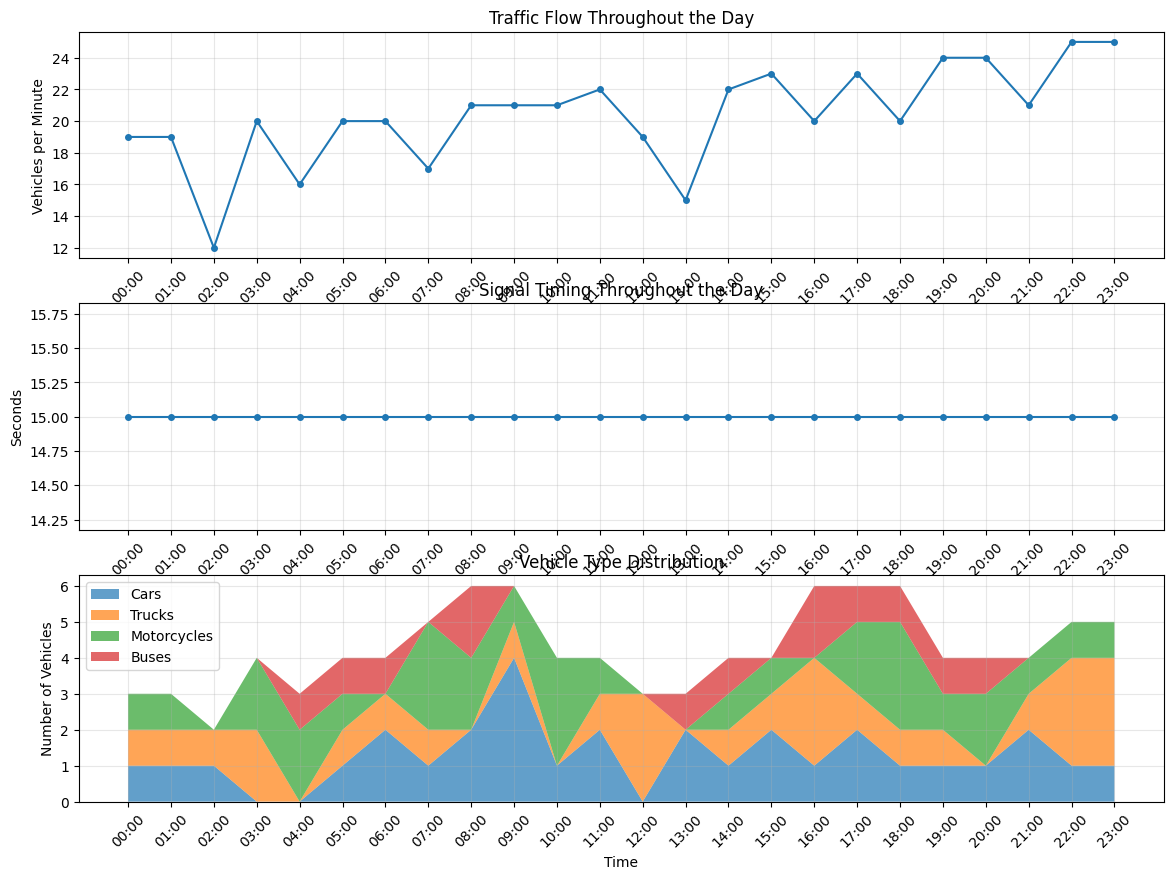


Generating traffic pattern visualization...


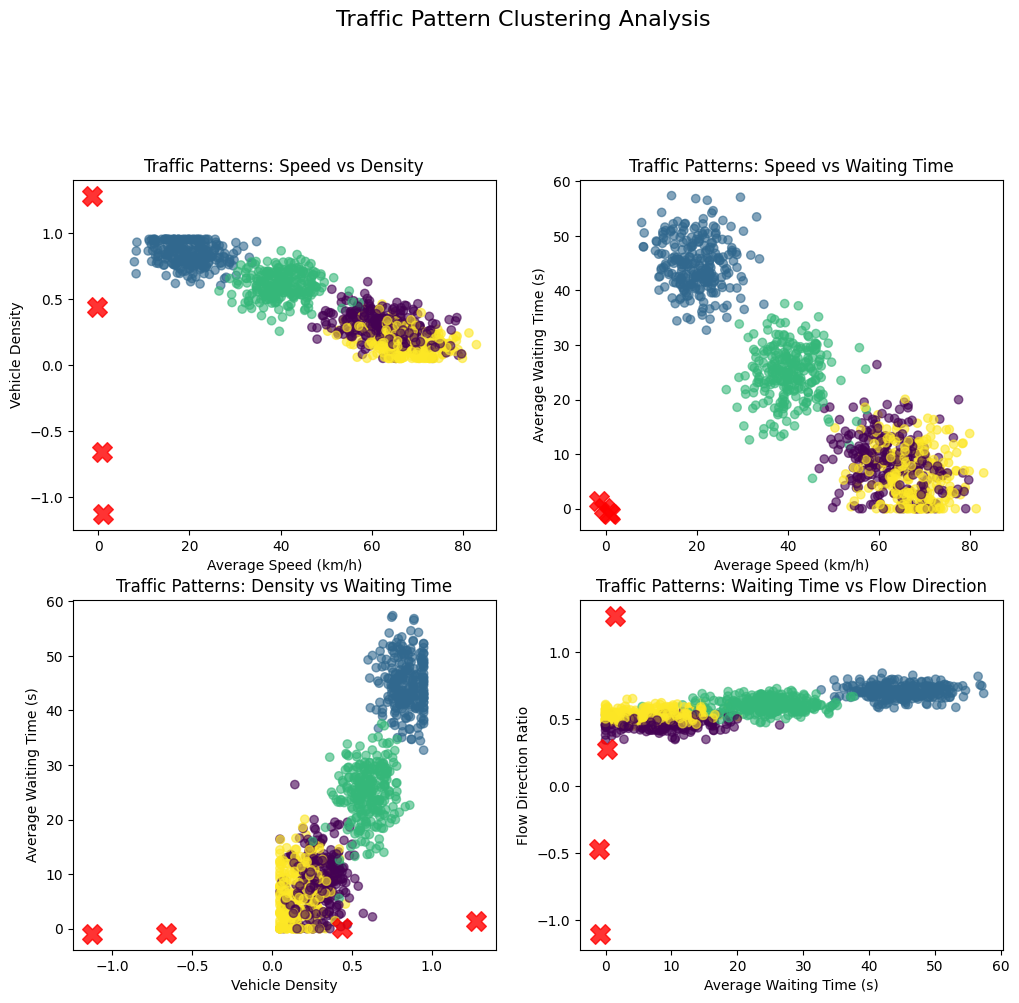


Generating signal timing strategy visualization...


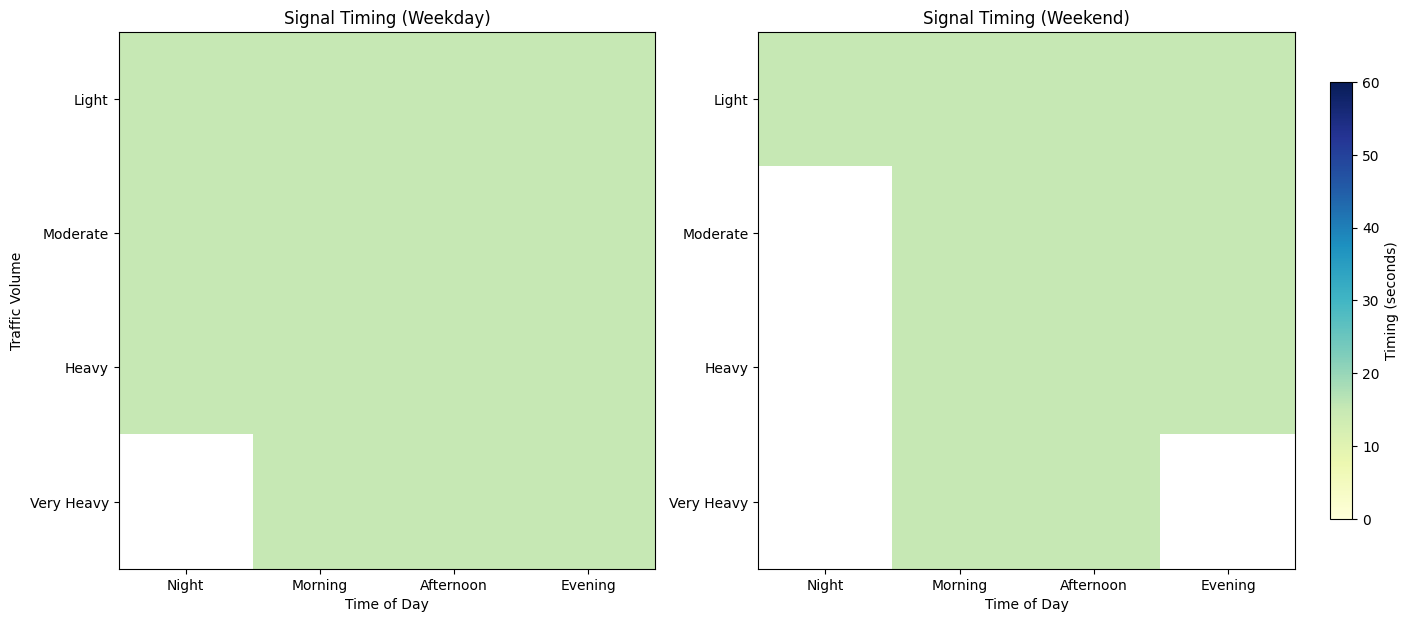

All models saved to 'models' directory

===== Simulation Complete =====


In [12]:
if __name__ == "__main__":
    main()